In [57]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries and modules
from sklearn import ensemble, preprocessing, linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_validate
from sklearn.metrics import r2_score, mean_squared_error

# Library for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Functions

In [126]:
# Function to print statistical values of SiteEnergyUse
def SiteEnergyUse(df):
    print("SiteEnergyUse")
    print("mean :",df['SiteEnergyUse(kBtu)'].mean())
    print("median :",df['SiteEnergyUse(kBtu)'].median())
    print("var :",df['SiteEnergyUse(kBtu)'].var())
    print("std :",df['SiteEnergyUse(kBtu)'].std())
    
# Function to print statistical values of GHGEmissions: 
def GHGEmissions(df):
    print("GHGEmissions")
    print("mean :",df['TotalGHGEmissions'].mean())
    print("median :",df['TotalGHGEmissions'].median())
    print("var :",df['TotalGHGEmissions'].var())
    print("std :",df['TotalGHGEmissions'].std())

# Function for one hot encoding of categorical features
# (Drop the first dummy feature)
def one_hot_encoder(Xx):
    
    """[summary]

    Args:
        Xx (pd.dataframe) : dataframe to test containing the different features
        cat_feat (list) : list of categorical features contained in the Xx dataframe
    """
    cat_feat = Xx.select_dtypes('object').columns.tolist()
        
    if len(cat_feat) != 0:
        X = pd.get_dummies(Xx, columns=cat_feat, drop_first=True)
    else:
        X = Xx
    
    return X

# Function to process modelling with cross validation     
def model_cv(algorithm, X, y, n_splits, n_repeats):
    
    """[summary]

    Args:
        X (pd.dataframe) : dataframe to test containing the different features
        y (array) : target array
        n_splits (int) : number of folds for cross-validation
        n_repeats (int) : number of cross-validation repetitions
    """
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    model = algorithm

    scores = cross_validate(
        model, X, y, cv=cv,
        scoring=('r2', 'neg_root_mean_squared_error'),
        return_train_score = True
    )
    
    train_scores_r2.append(scores['train_r2'].mean())
    test_scores_r2.append(scores['test_r2'].mean())
    
    return scores

# Function to print the results of cross validation
def print_results(scores, model_name, Xx_name, target):
    # Save results in a dataframe
    results = pd.DataFrame(scores)
    
    # Print title of results
    print(f'{model_name} on {Xx_name} to predict {target}')
    print('-'*20)
    
    # Print r2 scores
    print('mean r2 test =', "% 0.3f" % results['test_r2'].mean())
    print('mean r2 train =', "% 0.3f" % results['train_r2'].mean())
    print('-'*20)

    # Print RMSE scores
    print('mean RMSE test =', "% 0.1f" % results['test_neg_root_mean_squared_error'].mean())
    print('mean RMSE train =', "% 0.1f" % results['train_neg_root_mean_squared_error'].mean())
    print('*'*20)

# Function to process preprocessing, modeling and printing results
def preprocess_model_print(
    algorithm, Xx, y, n_splits, n_repeats, 
    model_name, Xx_name, target
):
    
    """[summary]

    Args:
        Xx (pd.dataframe) : dataframe to test containing the different features
        cat_feat (list) : list of categorical features contained in the Xx dataframe
        y (array) : target array
        n_splits (int) : number of folds for cross-validation
        n_repeats (int) : number of cross-validation repetitions
    """
    # one hot encoding for categorical features
    X = one_hot_encoder(Xx)
    
    # process modelling with cross validation
    scores = model_cv(algorithm, X, y, n_splits, n_repeats)
    
    # Print the results of cross validation
    print_results(scores, model_name, Xx_name, target)

# Function to display the dataframe of results (train and test)
# And print barplot of train and test scores depending on X matrix
def plot_results(list_X_names, train_scores_r2, test_scores_r2, model_name):
    # Create DataFrame containing scores and X matrices names
    df = pd.DataFrame(
    {
        'X_name': list_X_names + list_X_names,
        'scores': train_scores_r2 + test_scores_r2,
        'score_type': ['train'] * len(list_X_names) 
        + ['test'] * len(list_X_names)
    }
)
    print(f"Machine Learning results for {model_name} model:")
    print('-'*20)
    display(df)
    
    # Set seaborn plotting aesthetics
    sns.set()

    # Create grouped bar chart
    plt.figure(figsize=(15,6))
    sns.barplot(x='X_name', y='scores', hue='score_type', data=df)
    plt.title(f'Train & test scores by X matrix for {model_name}', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)
    plt.ylim(-0.2,1)
    plt.ylabel("scores", fontsize=18)
    plt.xlabel("X matrices", fontsize=18);
    plt.show()

# Function to predict SiteEnergyUse or GHGEmissions for different models
def predict_energy(algorithm):
    x_train = pd.get_dummies(
        X_train,
        columns=["PrimaryPropertyType"],
        drop_first=True)
    x_test = pd.get_dummies(
        X_test,
        columns=["PrimaryPropertyType"],
        drop_first=True)

    model = algorithm
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

# Function to visualize the differences between y_test & y_pred
def compare_test_and_pred(y_pred, model_name, target_name):
    x_ax = range(len(y_test))
    fig = plt.figure(figsize=(18,5))
    plt.plot(x_ax, y_test, label="original", linewidth=1)
    plt.plot(x_ax, y_pred, label="predicted", linewidth=1)
    plt.title(f"{target_name} : test and predicted data - {model_name}", fontsize=20)
    plt.xlabel('X-axis', fontsize=15)
    plt.ylabel('Y-axis', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best',fancybox=True, shadow=True, fontsize=15)
    plt.grid(True)
    plt.show()

### Read datasets 

In [3]:
# Read cleaned datasets

# Dataset with outliers
energy = pd.read_csv('energy.csv', sep=';')

# Dataset with ENERGYSTARScore
energy_star = pd.read_csv('energy_star.csv', sep=';')

# 1) Développement du modèle pour prédiction du SiteEnergyUse

### Choix des features pour la target "SiteEnergyUse"

In [4]:
# find the most correlated quantitative columns for SiteEnergyUse:
corr = abs(energy[[
    'SiteEnergyUse(kBtu)', 'PropertyGFABuilding(s)',
    'NumberofBuildings', 'NumberofFloors', 'prop_steam',
    'YearBuilt', 'prop_naturalgas', 'prop_electricity'
]].corr()).sort_values(by='SiteEnergyUse(kBtu)',
                       ascending=False)[['SiteEnergyUse(kBtu)']]

corr

,SiteEnergyUse(kBtu)
SiteEnergyUse(kBtu),1.000000
PropertyGFABuilding(s),0.870618
NumberofBuildings,0.704998
NumberofFloors,0.262928
prop_steam,0.178662
YearBuilt,0.066393
prop_naturalgas,0.063178
prop_electricity,0.004480


In [127]:
# Create a list containing all quantitative features
quant_feat_1 = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 
    'PropertyGFABuilding(s)', 'prop_electricity', 'prop_steam', 
    'prop_naturalgas'
]

# Create a list containing quantitative features correlated to more 
# than 0.1 and categorical features
# we remove the features correlated to each other at more than 0.6
# (NumberofBuilding(s) correlated to PropertyGFABuilding(s) at 0.73)
quant_feat_2 = [
    'NumberofFloors', 'PropertyGFABuilding(s)', 'prop_steam'
]

# Create a list containing the quantitative 
# features correlated to more than 0.4 and categorical features
quant_feat_3 = ['PropertyGFABuilding(s)']

# Create a list containing 'PrimaryPropertyType' and 'Neighborhood'
cat_feat_1 = ['PrimaryPropertyType', 'Neighborhood']

# Create a list containing 'PrimaryPropertyType'
cat_feat_2 = ['PrimaryPropertyType']

In [128]:
# Create X matrices
# Categorical features will then be encoded with OneHotEncoder
# (Without ENERGYSTARScore)
X1 = energy[quant_feat_1 + cat_feat_1]
X2 = energy[quant_feat_2 + cat_feat_1]
X3 = energy[quant_feat_3 + cat_feat_1]
X4 = energy[quant_feat_1 + cat_feat_2]
X5 = energy[quant_feat_2 + cat_feat_2]
X6 = energy[quant_feat_3 + cat_feat_2]
X7 = energy[quant_feat_1]
X8 = energy[quant_feat_2]
X9 = energy[quant_feat_3]

# Create 'array 'target' : SiteEnergyUse
ye = energy['SiteEnergyUse(kBtu)'].values

### Test different machine learning models on the different dataframes (+ cross-validation) and "SiteEnergyUse" target

### List of X matrices and X matrix names

In [129]:
# Create a list of different X matrices
list_X = [X1, X2, X3, X4, X5, X6, X7, X8, X9]
# Create a list of different X matrices names
list_X_names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9"]

### Linear Regression

In [49]:
# Print machine learning Results for Linear Regression model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=linear_model.LinearRegression(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="Linear Regression",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

Linear Regression on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.768
mean r2 train =  0.883
--------------------
mean RMSE test = -9474333.308
mean RMSE train = -8358675.088
********************
Linear Regression on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.755
mean r2 train =  0.876
--------------------
mean RMSE test = -10002272.524
mean RMSE train = -8654115.841
********************
Linear Regression on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.736
mean r2 train =  0.866
--------------------
mean RMSE test = -10478210.516
mean RMSE train = -9021997.107
********************
Linear Regression on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.769
mean r2 train =  0.881
--------------------
mean RMSE test = -9447928.957
mean RMSE train = -8412069.556
********************
Linear Regression on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.756
mean

Machine Learning results for Linear Regression model:
--------------------


,X_name,scores,score_type
0,X1,0.882982,train
1,X2,0.875628,train
2,X3,0.865780,train
3,X4,0.881493,train
4,X5,0.874102,train
5,X6,0.863209,train
6,X7,0.769567,train
7,X8,0.762969,train
8,X9,0.739001,train
9,X1,0.767772,test


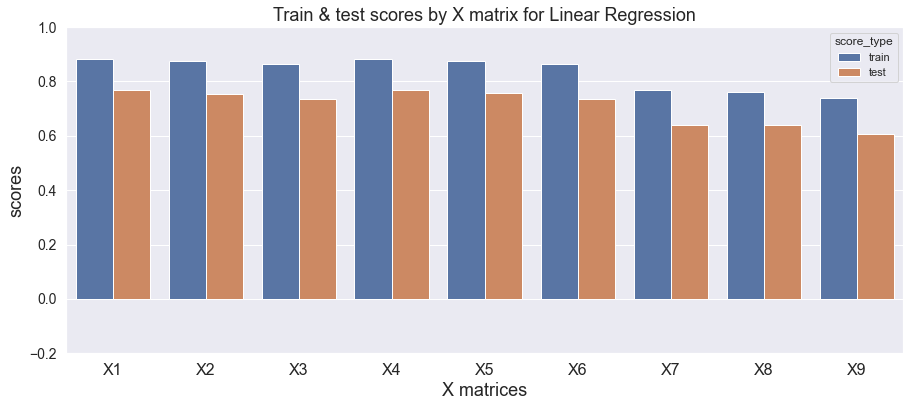

In [50]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Linear Regression")

### Linear SVR

In [43]:
# Print machine learning Results for Linear SVR model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=svm.LinearSVR(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="Linear SVR",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

Linear SVR on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.538
mean r2 train =  0.569
--------------------
mean RMSE test = -14990534.655
mean RMSE train = -15513518.430
********************
Linear SVR on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.531
mean r2 train =  0.587
--------------------
mean RMSE test = -14624489.968
mean RMSE train = -15895171.762
********************
Linear SVR on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.526
mean r2 train =  0.571
--------------------
mean RMSE test = -14408094.579
mean RMSE train = -16180692.290
********************
Linear SVR on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.353
mean r2 train =  0.403
--------------------
mean RMSE test = -17018646.596
mean RMSE train = -16592580.475
********************
Linear SVR on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test = -0.123
mean r2 train =  0.339
----------

Machine Learning results for Linear SVR model:
--------------------


,X_name,scores,score_type
0,X1,0.568899,train
1,X2,0.586718,train
2,X3,0.570816,train
3,X4,0.403287,train
4,X5,0.339190,train
5,X6,0.536726,train
6,X7,0.631034,train
7,X8,0.538329,train
8,X9,0.416683,train
9,X1,0.537556,test


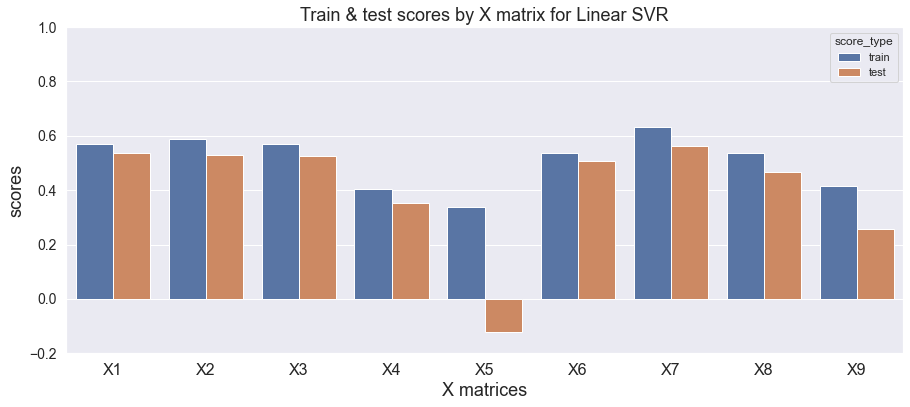

In [48]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Linear SVR")

### Random Forest

In [52]:
# Print machine learning Results for Random Forest model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=RandomForestRegressor(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="Random Forest",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

Random Forest on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.796
mean r2 train =  0.939
--------------------
mean RMSE test = -11282008.616
mean RMSE train = -6154309.748
********************
Random Forest on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.797
mean r2 train =  0.949
--------------------
mean RMSE test = -11291400.026
mean RMSE train = -5667505.593
********************
Random Forest on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.805
mean r2 train =  0.942
--------------------
mean RMSE test = -10978426.761
mean RMSE train = -6018134.311
********************
Random Forest on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.797
mean r2 train =  0.944
--------------------
mean RMSE test = -11267594.521
mean RMSE train = -5927879.511
********************
Random Forest on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.806
mean r2 train =  0.946

Machine Learning results for Random Forest model:
--------------------


,X_name,scores,score_type
0,X1,0.939170,train
1,X2,0.948904,train
2,X3,0.941778,train
3,X4,0.944056,train
4,X5,0.945641,train
5,X6,0.946025,train
6,X7,0.935230,train
7,X8,0.933953,train
8,X9,0.935439,train
9,X1,0.796366,test


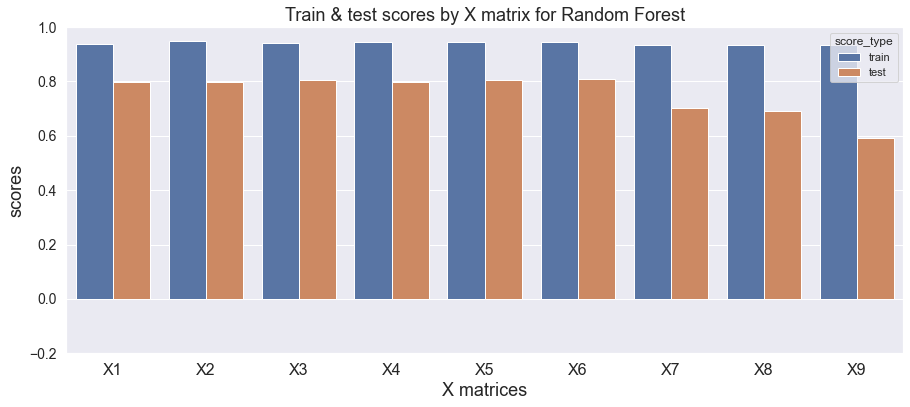

In [54]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Random Forest")

### Gradient Boosting

In [55]:
# Print machine learning Results for Gradient Boosting model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=ensemble.GradientBoostingRegressor(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="Gradient Boosting",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

Gradient Boosting on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.780
mean r2 train =  0.981
--------------------
mean RMSE test = -11630224.9
mean RMSE train = -3424057.3
********************
Gradient Boosting on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.778
mean r2 train =  0.977
--------------------
mean RMSE test = -11631756.8
mean RMSE train = -3740527.1
********************
Gradient Boosting on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.788
mean r2 train =  0.975
--------------------
mean RMSE test = -11385824.2
mean RMSE train = -3883730.1
********************
Gradient Boosting on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.782
mean r2 train =  0.980
--------------------
mean RMSE test = -11581451.5
mean RMSE train = -3469680.9
********************
Gradient Boosting on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.770
mean r2 train =  0

Machine Learning results for Gradient Boosting model:
--------------------


,X_name,scores,score_type
0,X1,0.980563,train
1,X2,0.976740,train
2,X3,0.974896,train
3,X4,0.980058,train
4,X5,0.976344,train
5,X6,0.973352,train
6,X7,0.973012,train
7,X8,0.964904,train
8,X9,0.957555,train
9,X1,0.780228,test


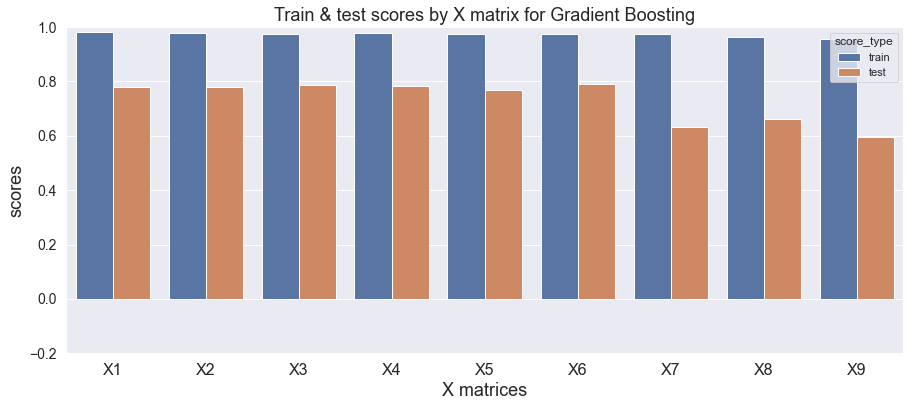

In [56]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Gradient Boosting")

### Lightgbm Regressor

In [58]:
# Print machine learning Results for lightgbm regressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=LGBMRegressor(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="lightgbm regressor",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

lightgbm regressor on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.624
mean r2 train =  0.742
--------------------
mean RMSE test = -14748836.0
mean RMSE train = -12897185.0
********************
lightgbm regressor on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.611
mean r2 train =  0.747
--------------------
mean RMSE test = -14645344.3
mean RMSE train = -12771890.6
********************
lightgbm regressor on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.579
mean r2 train =  0.673
--------------------
mean RMSE test = -15274224.5
mean RMSE train = -14521295.8
********************
lightgbm regressor on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.611
mean r2 train =  0.738
--------------------
mean RMSE test = -14986618.8
mean RMSE train = -13008820.4
********************
lightgbm regressor on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.518
mean r2 t

Machine Learning results for lightgbm regressor model:
--------------------


,X_name,scores,score_type
0,X1,0.742374,train
1,X2,0.746972,train
2,X3,0.673281,train
3,X4,0.738006,train
4,X5,0.696028,train
5,X6,0.612968,train
6,X7,0.735612,train
7,X8,0.680116,train
8,X9,0.430325,train
9,X1,0.624149,test


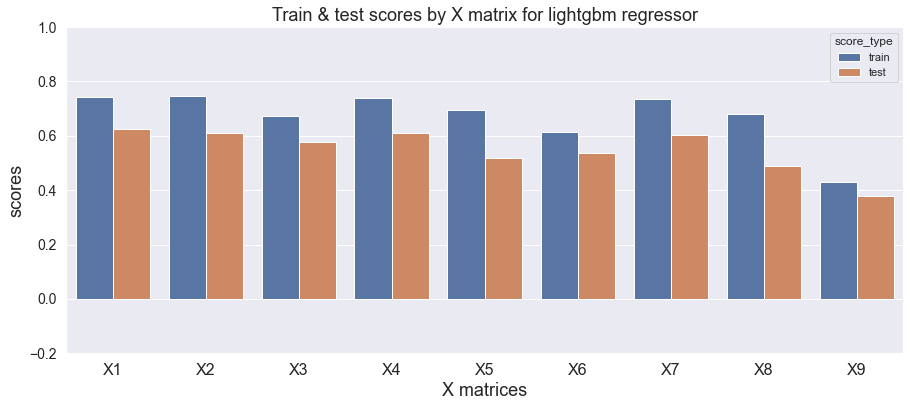

In [59]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="lightgbm regressor")

### SGDRegressor

In [61]:
# Print machine learning Results for SGD regressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=linear_model.SGDRegressor(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="SGD regressor",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

SGD regressor on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test = -11361238230150456933351424.000
mean r2 train = -10985733775685418833936384.000
--------------------
mean RMSE test = -58054213375567757312.0
mean RMSE train = -47253025611150999552.0
********************
SGD regressor on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test = -1914366340625218911862784.000
mean r2 train = -1421097091630034430459904.000
--------------------
mean RMSE test = -20789922086528991232.0
mean RMSE train = -25615945826108178432.0
********************
SGD regressor on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test = -1596929547266727878852608.000
mean r2 train = -1622432688541712280190976.000
--------------------
mean RMSE test = -19102133809148813312.0
mean RMSE train = -19592656963561877504.0
********************
SGD regressor on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test = -62816358617083864265261056.000
mean r2 t

### KneighborsRegressor

In [62]:
# Print machine learning Results for KNeighborsRegressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=KNeighborsRegressor(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="KNeighborsRegressor",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

KNeighborsRegressor on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.462
mean r2 train =  0.628
--------------------
mean RMSE test = -17150588.2
mean RMSE train = -15459627.4
********************
KNeighborsRegressor on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.462
mean r2 train =  0.627
--------------------
mean RMSE test = -17160949.1
mean RMSE train = -15467302.6
********************
KNeighborsRegressor on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.461
mean r2 train =  0.627
--------------------
mean RMSE test = -17162531.9
mean RMSE train = -15468400.5
********************
KNeighborsRegressor on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.462
mean r2 train =  0.628
--------------------
mean RMSE test = -17150588.8
mean RMSE train = -15459627.6
********************
KNeighborsRegressor on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.462
mean

### Decision Tree Regressor

In [63]:
# Print machine learning Results for DecisionTreeRegressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=DecisionTreeRegressor(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="DecisionTreeRegressor",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

DecisionTreeRegressor on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.779
mean r2 train =  1.000
--------------------
mean RMSE test = -11650299.4
mean RMSE train = -175723.7
********************
DecisionTreeRegressor on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.773
mean r2 train =  0.999
--------------------
mean RMSE test = -11800296.2
mean RMSE train = -717339.9
********************
DecisionTreeRegressor on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.786
mean r2 train =  0.999
--------------------
mean RMSE test = -11479816.6
mean RMSE train = -790020.2
********************
DecisionTreeRegressor on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.771
mean r2 train =  1.000
--------------------
mean RMSE test = -11837894.8
mean RMSE train = -175723.7
********************
DecisionTreeRegressor on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.782
me

Machine Learning results for DecisionTree Regressor model:
--------------------


,X_name,scores,score_type
0,X1,0.999946,train
1,X2,0.999070,train
2,X3,0.998875,train
3,X4,0.999946,train
4,X5,0.999070,train
5,X6,0.998874,train
6,X7,0.999946,train
7,X8,0.999039,train
8,X9,0.998739,train
9,X1,0.778518,test


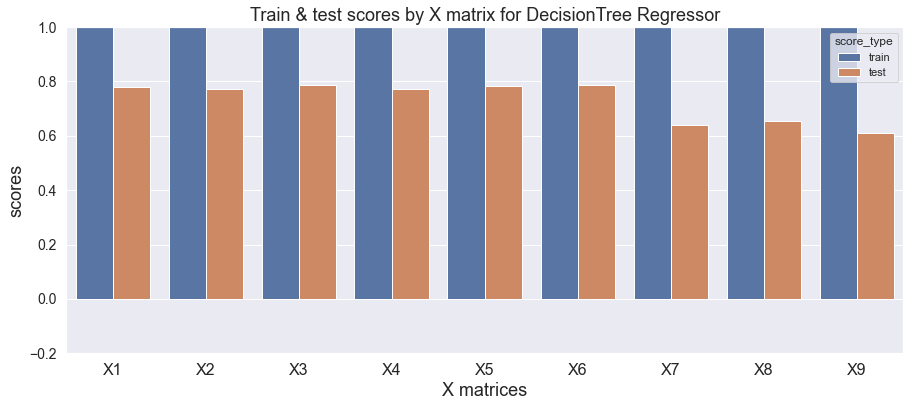

In [64]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="DecisionTree Regressor")

### AdaBoost Regressor

In [65]:
# Print machine learning Results for AdaBoostRegressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=ensemble.AdaBoostRegressor(),
        Xx=x, y=ye,
        n_splits=5, n_repeats=3,
        model_name="AdaBoost Regressor",
        Xx_name=x_names,
        target='SiteEnergyUse(kBtu)',
)

AdaBoost Regressor on X1 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.547
mean r2 train =  0.857
--------------------
mean RMSE test = -15769924.0
mean RMSE train = -9117814.4
********************
AdaBoost Regressor on X2 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.543
mean r2 train =  0.875
--------------------
mean RMSE test = -15164034.0
mean RMSE train = -8542140.3
********************
AdaBoost Regressor on X3 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.678
mean r2 train =  0.909
--------------------
mean RMSE test = -13525797.4
mean RMSE train = -7298082.8
********************
AdaBoost Regressor on X4 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.554
mean r2 train =  0.866
--------------------
mean RMSE test = -15629899.9
mean RMSE train = -8702656.0
********************
AdaBoost Regressor on X5 to predict SiteEnergyUse(kBtu)
--------------------
mean r2 test =  0.606
mean r2 train

Machine Learning results for AdaBoost Regressor model:
--------------------


,X_name,scores,score_type
0,X1,0.857008,train
1,X2,0.874644,train
2,X3,0.908758,train
3,X4,0.865541,train
4,X5,0.896485,train
5,X6,0.920070,train
6,X7,0.895077,train
7,X8,0.889070,train
8,X9,0.842660,train
9,X1,0.547302,test


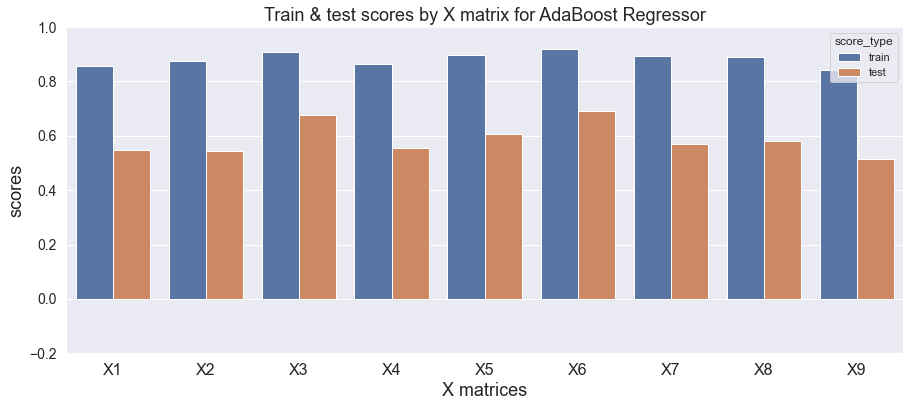

In [67]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="AdaBoost Regressor")

### Conclusion for Site Energy Use
Best model is 
- algorithm : Random Forest Regressor 
- on matrix X6 : 2 features : PropertyGFABuilding(s) & PrimaryPropertyType

The feature 'Neighborhood' is useless

## Visualize differences of predictions between the different models

In [95]:
# Train_test_split (test set = 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X6, 
    ye, 
    test_size=0.20, 
    stratify=X6['PrimaryPropertyType'],
    random_state=40)

In [96]:
# Create the list of tested algorithms
algorithms = [
    linear_model.LinearRegression(), 
    svm.LinearSVR(), 
    RandomForestRegressor(), 
    LGBMRegressor(), 
    ensemble.GradientBoostingRegressor(), 
    KNeighborsRegressor(), 
    DecisionTreeRegressor(), 
    linear_model.SGDRegressor(), 
    ensemble.AdaBoostRegressor()
]

# Create the list of tested algorithm names
algorithm_names = [
    "LinearRegression", "LinearSVR", "RandomForestRegressor", 
    "LGBMRegressor", "GradientBoosting", "KNeighborsRegressor", 
    "DecisionTreeRegressor", "SGDRegression", "AdaBoostRegressor"
]

### Comparisons

In [130]:
# Predict SiteEnergyUse with different models
# and save keys and values in a dictionnary
models_and_pred_energies = {}
for a, m in zip(algorithms, algorithm_names):
    y_pred = predict_energy(a)
    models_and_pred_energies[m] = y_pred

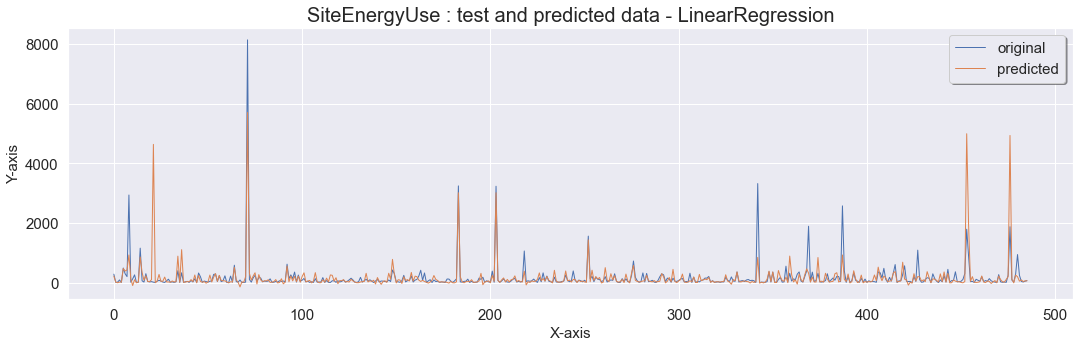

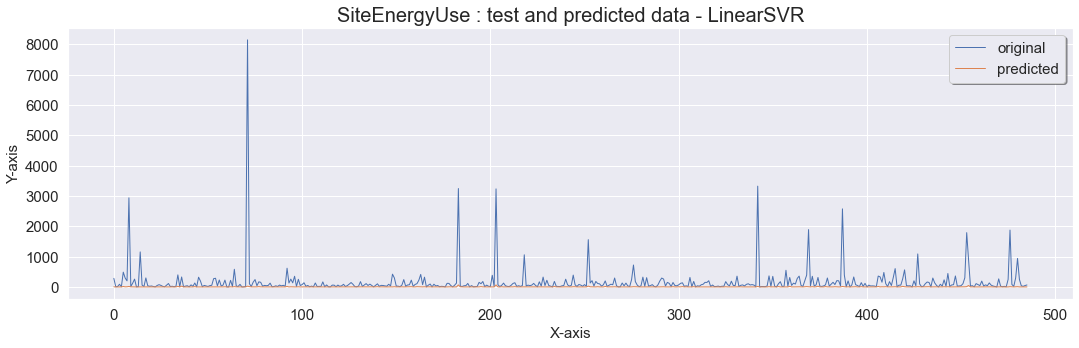

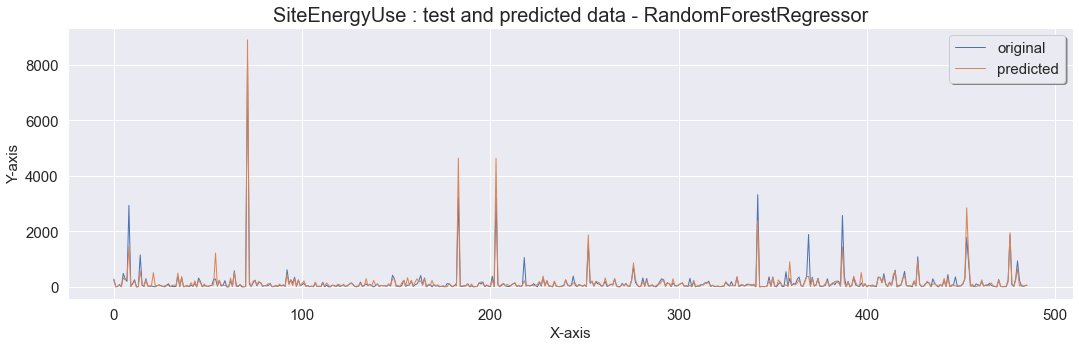

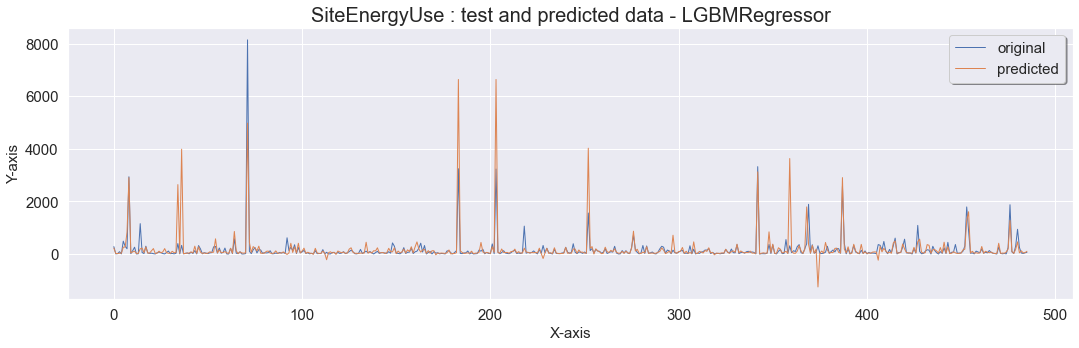

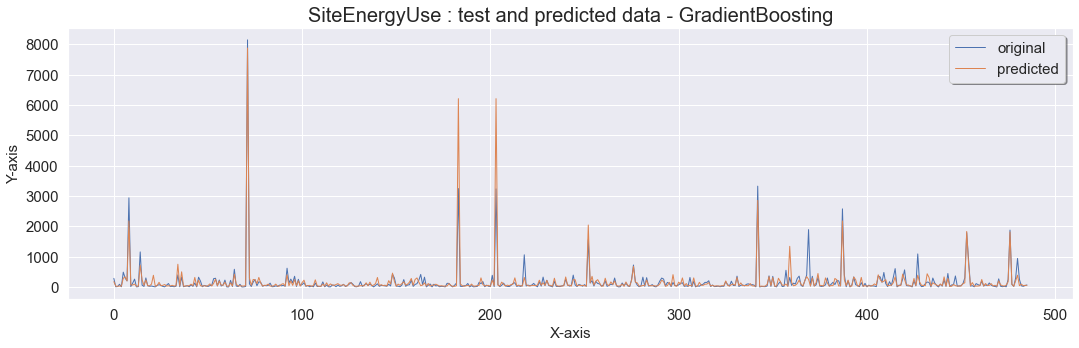

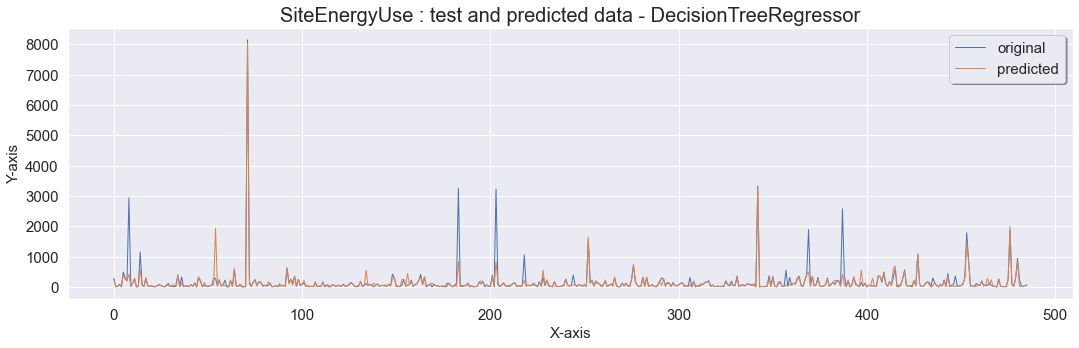

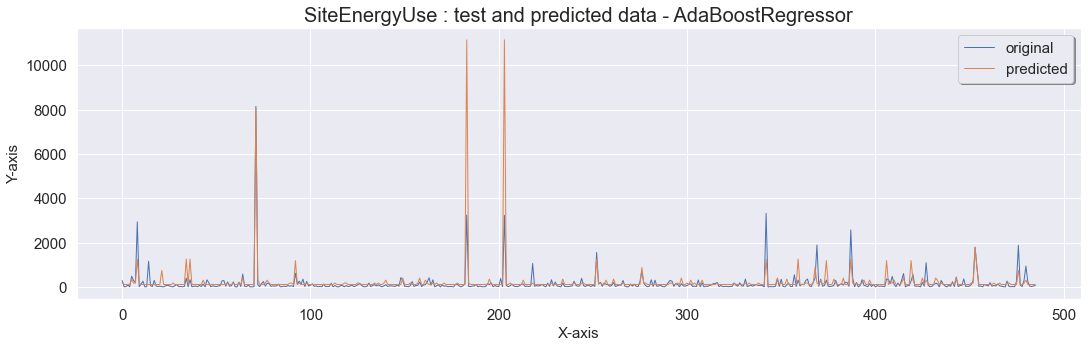

In [132]:
# Compare predictions of algorithms
for k, v in zip(models_and_pred_energies.keys(), models_and_pred_energies.values()):
    compare_test_and_pred(v, k, "SiteEnergyUse")

# TotalGHGEmissions

### Without ENERGYSTARScore

In [100]:
# find the most correlated quantitative columns for TotalGHGEmissions:
corr = abs(energy[[
    'TotalGHGEmissions', 'PropertyGFABuilding(s)',
    'NumberofBuildings', 'NumberofFloors', 'prop_steam',
    'YearBuilt', 'prop_naturalgas', 'prop_electricity'
]].corr()).sort_values(by='TotalGHGEmissions',
                       ascending=False)[['TotalGHGEmissions']]

corr

,TotalGHGEmissions
TotalGHGEmissions,1.000000
PropertyGFABuilding(s),0.601271
NumberofBuildings,0.412661
prop_steam,0.289912
NumberofFloors,0.158552
prop_electricity,0.120633
YearBuilt,0.044555
prop_naturalgas,0.025433


In [133]:
# Create a list containing all quantitative features
quant_feat_1 = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 
    'PropertyGFABuilding(s)', 'prop_electricity', 'prop_steam', 
    'prop_naturalgas'
]

# Create a list containing quantitative features correlated to more 
# than 0.1 and categorical features
# we remove the features correlated to each other at more than 0.6
# (NumberofBuilding(s) correlated to PropertyGFABuilding(s) at 0.73)
quant_feat_2 = [
    'NumberofFloors', 'PropertyGFABuilding(s)', 'prop_steam',
    'prop_electricity'
]

# Create a list containing the quantitative 
# features correlated to more than 0.4 and categorical features
quant_feat_3 = ['PropertyGFABuilding(s)']

# Create a list containing 'PrimaryPropertyType' and 'Neighborhood'
cat_feat_1 = ['PrimaryPropertyType', 'Neighborhood']

# Create a list containing 'PrimaryPropertyType'
cat_feat_2 = ['PrimaryPropertyType']

In [134]:
# Create X matrices
# Categorical features will then be encoded with OneHotEncoder
# (Without ENERGYSTARScore)
X1 = energy[quant_feat_1 + cat_feat_1]
X2 = energy[quant_feat_2 + cat_feat_1]
X3 = energy[quant_feat_3 + cat_feat_1]
X4 = energy[quant_feat_1 + cat_feat_2]
X5 = energy[quant_feat_2 + cat_feat_2]
X6 = energy[quant_feat_3 + cat_feat_2]
X7 = energy[quant_feat_1]
X8 = energy[quant_feat_2]
X9 = energy[quant_feat_3]

# Création array 'target' : TotalGHGEmissions
yg = energy['TotalGHGEmissions'].values

### Test different machine learning models on the different dataframes (+ cross-validation) and target"TotalGHGEmissions"

### List of X matrices and X matrix names

In [135]:
# Create a list of different X matrices
list_X = [X1, X2, X3, X4, X5, X6, X7, X8, X9]
# Create a list of different X matrices names
list_X_names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9"]

### Linear Regression

In [109]:
# Print machine learning Results for Linear Regression model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=linear_model.LinearRegression(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="Linear Regression",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

Linear Regression on X1 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.529
mean r2 train =  0.738
--------------------
mean RMSE test = -390.9
mean RMSE train = -334.2
********************
Linear Regression on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.562
mean r2 train =  0.734
--------------------
mean RMSE test = -372.0
mean RMSE train = -336.4
********************
Linear Regression on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.522
mean r2 train =  0.699
--------------------
mean RMSE test = -383.2
mean RMSE train = -357.8
********************
Linear Regression on X4 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.531
mean r2 train =  0.734
--------------------
mean RMSE test = -391.3
mean RMSE train = -336.5
********************
Linear Regression on X5 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.564
mean r2 train =  0.730
--------------------
mean RMSE test = -37

Machine Learning results for Linear Regression model:
--------------------


,X_name,scores,score_type
0,X1,0.737573,train
1,X2,0.734064,train
2,X3,0.698952,train
3,X4,0.733948,train
4,X5,0.730269,train
5,X6,0.690472,train
6,X7,0.470798,train
7,X8,0.451836,train
8,X9,0.363945,train
9,X1,0.529050,test


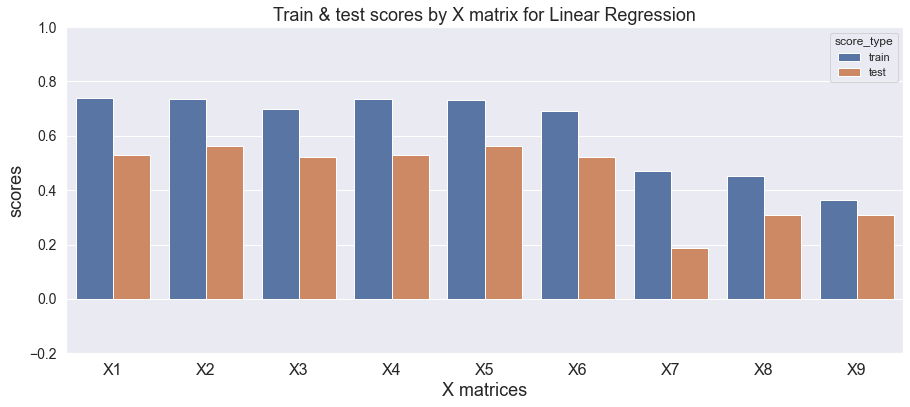

In [110]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Linear Regression")

### Linear SVR

In [111]:
# Print machine learning Results for Linear SVR model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=svm.LinearSVR(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="Linear SVR",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

Linear SVR on X1 to predict TotalGHGEmissions
--------------------
mean r2 test = -0.910
mean r2 train = -0.091
--------------------
mean RMSE test = -724.7
mean RMSE train = -653.2
********************
Linear SVR on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.017
mean r2 train = -0.842
--------------------
mean RMSE test = -613.7
mean RMSE train = -746.3
********************
Linear SVR on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.184
mean r2 train =  0.140
--------------------
mean RMSE test = -563.9
mean RMSE train = -596.2
********************
Linear SVR on X4 to predict TotalGHGEmissions
--------------------
mean r2 test = -0.655
mean r2 train = -0.450
--------------------
mean RMSE test = -684.4
mean RMSE train = -721.9
********************
Linear SVR on X5 to predict TotalGHGEmissions
--------------------
mean r2 test = -0.223
mean r2 train = -0.296
--------------------
mean RMSE test = -673.7
mean RMSE train = -681.7
******

Machine Learning results for Linear SVR model:
--------------------


,X_name,scores,score_type
0,X1,-0.090605,train
1,X2,-0.842344,train
2,X3,0.139907,train
3,X4,-0.449760,train
4,X5,-0.295719,train
5,X6,0.067967,train
6,X7,-0.242327,train
7,X8,-0.176730,train
8,X9,0.116934,train
9,X1,-0.910296,test


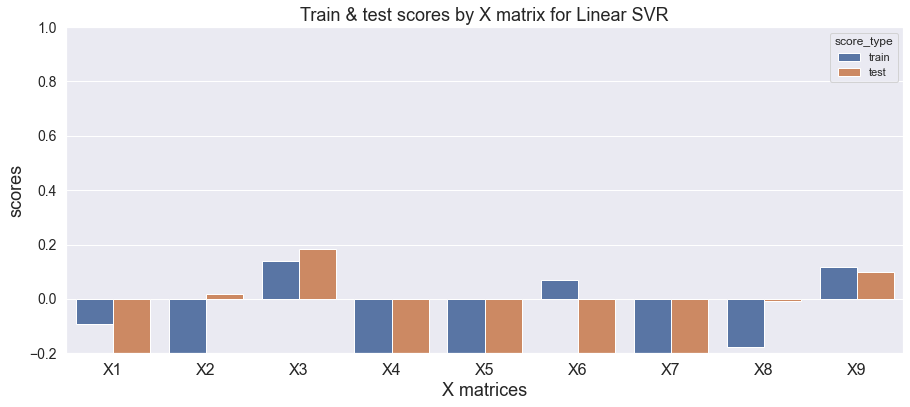

In [112]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Linear SVR")

### Random Forest

In [113]:
# Print machine learning Results for Random Forest model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=RandomForestRegressor(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="Random Forest",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

Random Forest on X1 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.805
mean r2 train =  0.975
--------------------
mean RMSE test = -257.4
mean RMSE train = -102.2
********************
Random Forest on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.815
mean r2 train =  0.976
--------------------
mean RMSE test = -248.4
mean RMSE train = -99.0
********************
Random Forest on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.813
mean r2 train =  0.977
--------------------
mean RMSE test = -244.8
mean RMSE train = -97.0
********************
Random Forest on X4 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.799
mean r2 train =  0.974
--------------------
mean RMSE test = -262.9
mean RMSE train = -103.2
********************
Random Forest on X5 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.829
mean r2 train =  0.978
--------------------
mean RMSE test = -238.7
mean RMSE train = 

Machine Learning results for Random Forest model:
--------------------


,X_name,scores,score_type
0,X1,0.974828,train
1,X2,0.976080,train
2,X3,0.977264,train
3,X4,0.974477,train
4,X5,0.978436,train
5,X6,0.977339,train
6,X7,0.964079,train
7,X8,0.969557,train
8,X9,0.933307,train
9,X1,0.805377,test


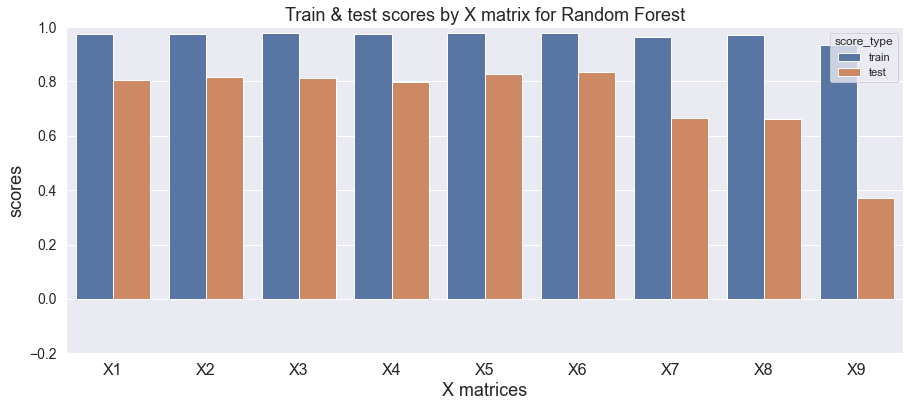

In [114]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Random Forest")

### Gradient Boosting

In [115]:
# Print machine learning Results for Gradient Boosting model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=ensemble.GradientBoostingRegressor(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="Gradient Boosting",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

Gradient Boosting on X1 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.814
mean r2 train =  0.990
--------------------
mean RMSE test = -241.7
mean RMSE train = -65.4
********************
Gradient Boosting on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.819
mean r2 train =  0.989
--------------------
mean RMSE test = -239.4
mean RMSE train = -69.5
********************
Gradient Boosting on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.830
mean r2 train =  0.972
--------------------
mean RMSE test = -227.2
mean RMSE train = -108.4
********************
Gradient Boosting on X4 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.809
mean r2 train =  0.990
--------------------
mean RMSE test = -246.4
mean RMSE train = -66.4
********************
Gradient Boosting on X5 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.818
mean r2 train =  0.988
--------------------
mean RMSE test = -240.1

Machine Learning results for Gradient Boosting model:
--------------------


,X_name,scores,score_type
0,X1,0.989835,train
1,X2,0.988555,train
2,X3,0.971794,train
3,X4,0.989516,train
4,X5,0.988279,train
5,X6,0.968626,train
6,X7,0.981613,train
7,X8,0.979589,train
8,X9,0.933800,train
9,X1,0.814087,test


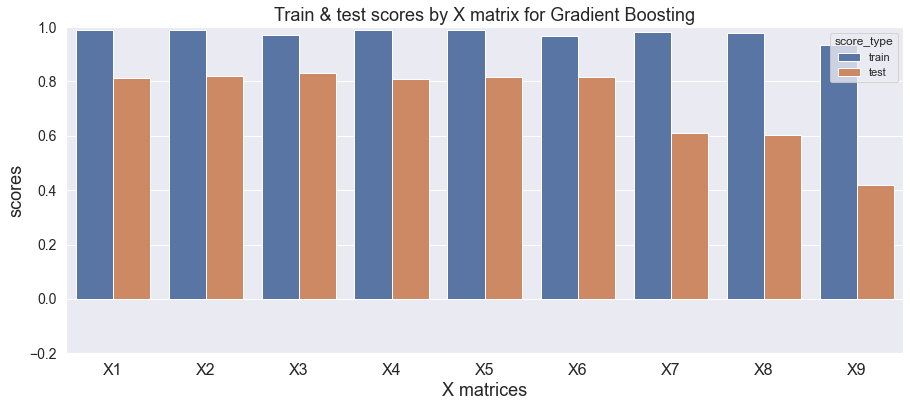

In [116]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Gradient Boosting")

### Lightgbm Regressor

In [117]:
# Print machine learning Results for lightgbm regressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=LGBMRegressor(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="lightgbm regressor",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

lightgbm regressor on X1 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.603
mean r2 train =  0.787
--------------------
mean RMSE test = -387.1
mean RMSE train = -300.5
********************
lightgbm regressor on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.614
mean r2 train =  0.779
--------------------
mean RMSE test = -379.7
mean RMSE train = -305.8
********************
lightgbm regressor on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.530
mean r2 train =  0.721
--------------------
mean RMSE test = -409.1
mean RMSE train = -343.4
********************
lightgbm regressor on X4 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.605
mean r2 train =  0.785
--------------------
mean RMSE test = -386.8
mean RMSE train = -301.7
********************
lightgbm regressor on X5 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.615
mean r2 train =  0.777
--------------------
mean RMSE test 

Machine Learning results for lightgbm regressor model:
--------------------


,X_name,scores,score_type
0,X1,0.787106,train
1,X2,0.779374,train
2,X3,0.721182,train
3,X4,0.785249,train
4,X5,0.777488,train
5,X6,0.653165,train
6,X7,0.784362,train
7,X8,0.770069,train
8,X9,0.338073,train
9,X1,0.602842,test


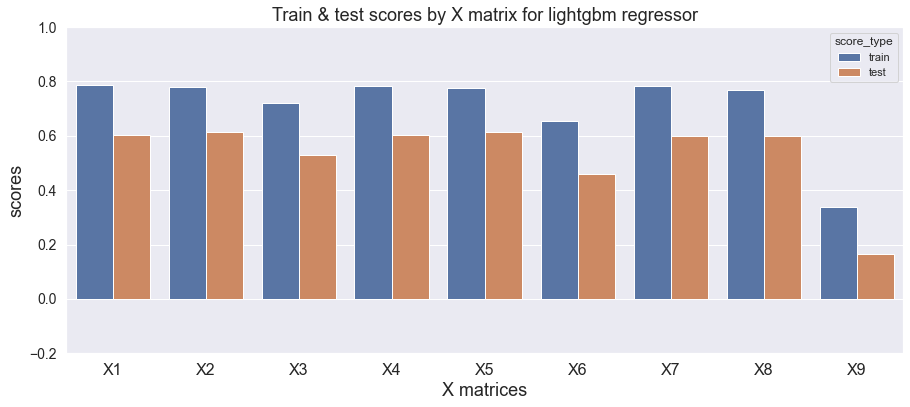

In [118]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="lightgbm regressor")

### Decision Tree Regressor

In [120]:
# Print machine learning Results for DecisionTreeRegressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=DecisionTreeRegressor(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="DecisionTreeRegressor",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

DecisionTreeRegressor on X1 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.744
mean r2 train =  1.000
--------------------
mean RMSE test = -273.0
mean RMSE train = -1.2
********************
DecisionTreeRegressor on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.762
mean r2 train =  1.000
--------------------
mean RMSE test = -267.1
mean RMSE train = -1.2
********************
DecisionTreeRegressor on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.799
mean r2 train =  0.997
--------------------
mean RMSE test = -263.3
mean RMSE train = -32.2
********************
DecisionTreeRegressor on X4 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.720
mean r2 train =  1.000
--------------------
mean RMSE test = -282.7
mean RMSE train = -1.2
********************
DecisionTreeRegressor on X5 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.769
mean r2 train =  1.000
--------------------
mean RM

Machine Learning results for DecisionTree Regressor model:
--------------------


,X_name,scores,score_type
0,X1,0.999996,train
1,X2,0.999996,train
2,X3,0.997289,train
3,X4,0.999996,train
4,X5,0.999996,train
5,X6,0.997287,train
6,X7,0.999996,train
7,X8,0.999996,train
8,X9,0.997031,train
9,X1,0.743534,test


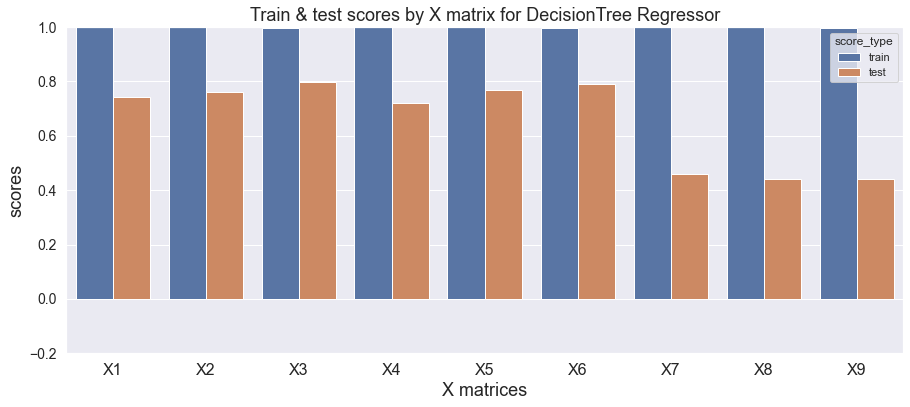

In [121]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="DecisionTree Regressor")

### AdaBoost Regressor

In [122]:
# Print machine learning Results for AdaBoostRegressor model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=ensemble.AdaBoostRegressor(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="AdaBoost Regressor",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

AdaBoost Regressor on X1 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.616
mean r2 train =  0.862
--------------------
mean RMSE test = -358.1
mean RMSE train = -234.4
********************
AdaBoost Regressor on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.616
mean r2 train =  0.873
--------------------
mean RMSE test = -353.8
mean RMSE train = -217.9
********************
AdaBoost Regressor on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.596
mean r2 train =  0.887
--------------------
mean RMSE test = -328.5
mean RMSE train = -214.9
********************
AdaBoost Regressor on X4 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.599
mean r2 train =  0.843
--------------------
mean RMSE test = -367.2
mean RMSE train = -246.3
********************
AdaBoost Regressor on X5 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.622
mean r2 train =  0.882
--------------------
mean RMSE test 

Machine Learning results for AdaBoost Regressor model:
--------------------


,X_name,scores,score_type
0,X1,0.861749,train
1,X2,0.873176,train
2,X3,0.886789,train
3,X4,0.843303,train
4,X5,0.881544,train
5,X6,0.878201,train
6,X7,0.780589,train
7,X8,0.843373,train
8,X9,0.723935,train
9,X1,0.615767,test


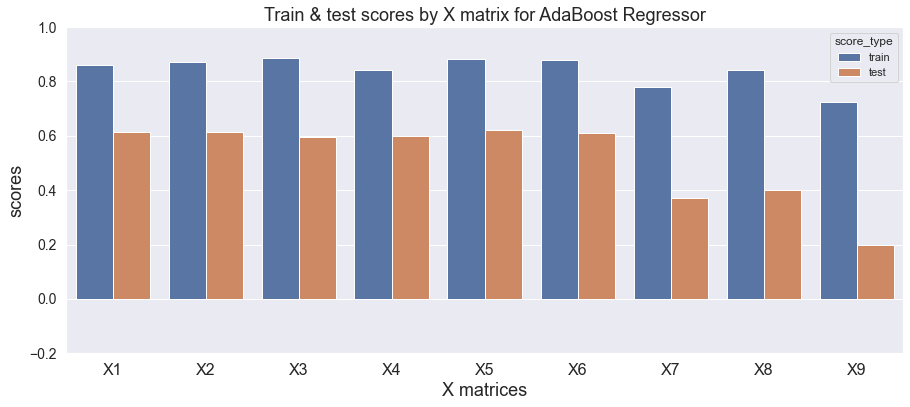

In [123]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="AdaBoost Regressor")

### Conclusion for TotalGHGEmissions
Best model is 
- algorithm : Random Forest Regressor 
- on matrix X6 : 2 features : PropertyGFABuilding(s) & PrimaryPropertyType

The feature 'Neighborhood' is useless

## Visualize differences of predictions between the different models

In [136]:
# Train_test_split (test set = 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X6, 
    yg, 
    test_size=0.20, 
    stratify=X6['PrimaryPropertyType'],
    random_state=40)

In [137]:
# Create the list of tested algorithms
algorithms = [
    linear_model.LinearRegression(), 
    svm.LinearSVR(), 
    RandomForestRegressor(), 
    LGBMRegressor(), 
    ensemble.GradientBoostingRegressor(), 
    DecisionTreeRegressor(), 
    ensemble.AdaBoostRegressor()
]

# Create the list of tested algorithm names
algorithm_names = [
    "LinearRegression", "LinearSVR", "RandomForestRegressor", 
    "LGBMRegressor", "GradientBoosting", 
    "DecisionTreeRegressor", "AdaBoostRegressor"
]

In [138]:
# Predict SiteEnergyUse with different models
# and save keys and values in a dictionnary
models_and_pred_energies = {}
for a, m in zip(algorithms, algorithm_names):
    y_pred = predict_energy(a)
    models_and_pred_energies[m] = y_pred

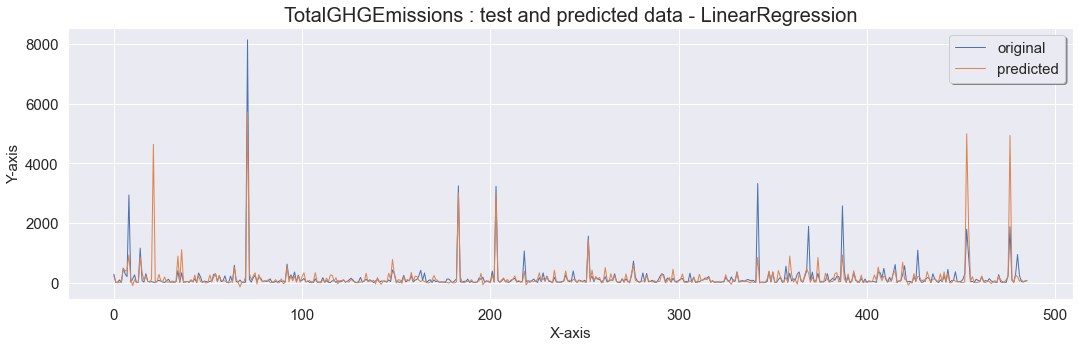

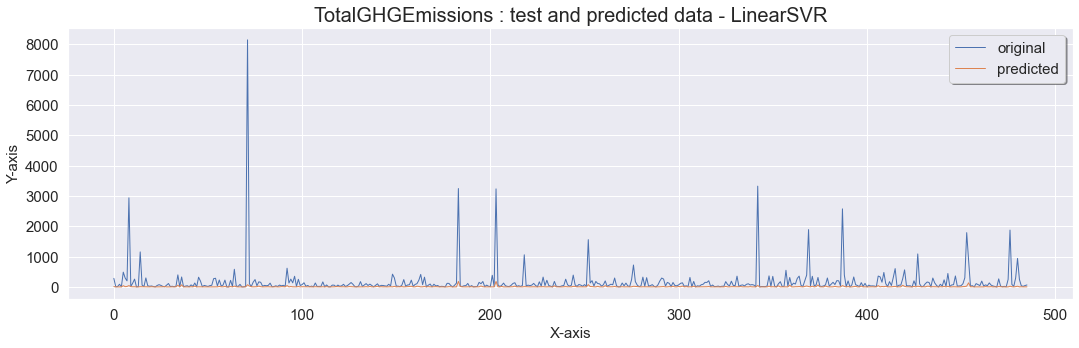

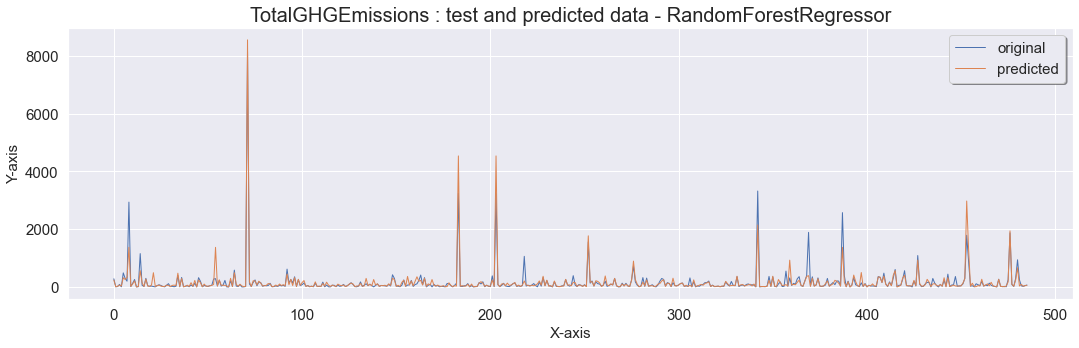

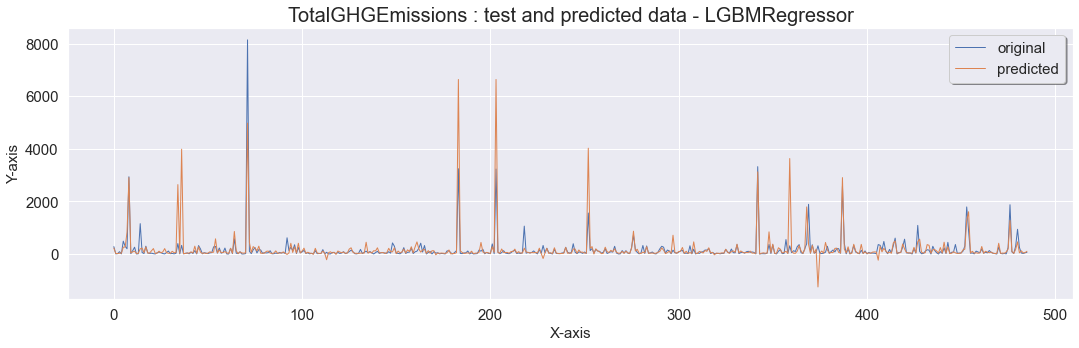

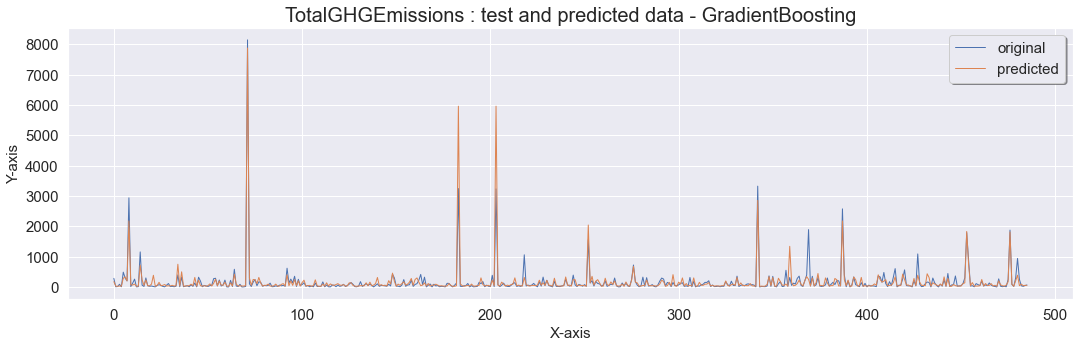

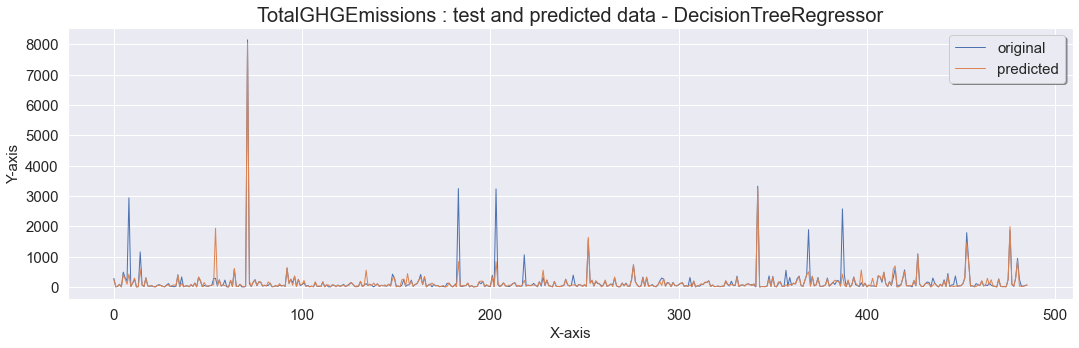

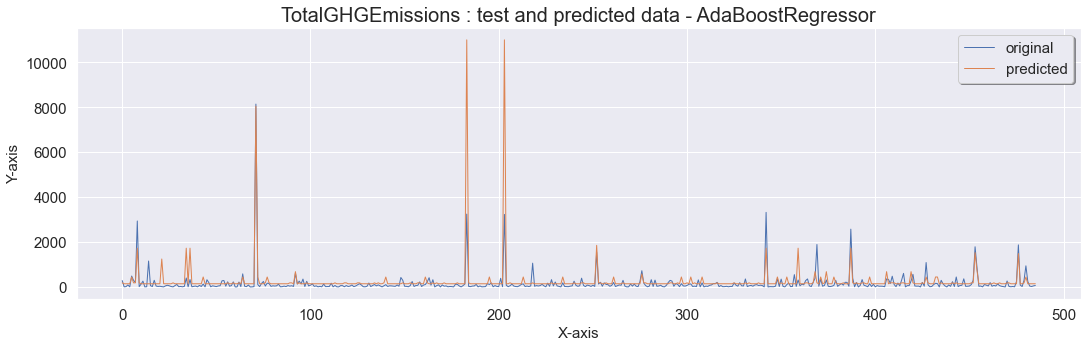

In [139]:
# Compare predictions of algorithms
for k, v in zip(models_and_pred_energies.keys(), models_and_pred_energies.values()):
    compare_test_and_pred(v, k, "TotalGHGEmissions")

## TotalGHGEmissions with or without ENERGYSTARScore
### (using energy_star dataframe)

In [141]:
# find the most correlated quantitative columns for SiteEnergyUse:
corr = abs(energy_star[[
    'TotalGHGEmissions', 'PropertyGFABuilding(s)',
    'NumberofBuildings', 'NumberofFloors', 'prop_steam',
    'YearBuilt', 'prop_naturalgas', 'prop_electricity',
    'ENERGYSTARScore'
]].corr()).sort_values(by='TotalGHGEmissions',
                       ascending=False)[['TotalGHGEmissions']]

corr

,TotalGHGEmissions
TotalGHGEmissions,1.000000
PropertyGFABuilding(s),0.532523
NumberofBuildings,0.503008
prop_steam,0.311053
NumberofFloors,0.176892
prop_electricity,0.125371
ENERGYSTARScore,0.098119
YearBuilt,0.061116
prop_naturalgas,0.020316


In [142]:
# Create a list containing all quantitative features + 'ENERGYSTARScore'
quant_feat_1 = [
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 
    'PropertyGFABuilding(s)', 'prop_electricity', 'prop_steam', 
    'prop_naturalgas', 'ENERGYSTARScore'
]

# Create a list containing quantitative features correlated to more 
# than 0.1 and categorical features + 'ENERGYSTARScore'
# we remove the features correlated to each other at more than 0.6
# (NumberofBuilding(s) correlated to PropertyGFABuilding(s) at 0.73)
quant_feat_2 = [
    'NumberofFloors', 'PropertyGFABuilding(s)', 'prop_steam',
    'prop_electricity', 'ENERGYSTARScore'
]

# Create a list containing the quantitative + 'ENERGYSTARScore'
# features correlated to more than 0.4 and categorical features
quant_feat_3 = ['PropertyGFABuilding(s)', 'ENERGYSTARScore']

# Create a list containing 'PrimaryPropertyType' and 'Neighborhood'
cat_feat_1 = ['PrimaryPropertyType', 'Neighborhood']

# Create a list containing 'PrimaryPropertyType'
cat_feat_2 = ['PrimaryPropertyType']

In [143]:
# Create X matrices
# Categorical features will then be encoded with OneHotEncoder
# (With ENERGYSTARScore)
X1 = energy[quant_feat_1 + cat_feat_1]
X2 = energy[quant_feat_2 + cat_feat_1]
X3 = energy[quant_feat_3 + cat_feat_1]
X4 = energy[quant_feat_1 + cat_feat_2]
X5 = energy[quant_feat_2 + cat_feat_2]
X6 = energy[quant_feat_3 + cat_feat_2]
X7 = energy[quant_feat_1]
X8 = energy[quant_feat_2]
X9 = energy[quant_feat_3]

# Création array 'target' : TotalGHGEmissions
yg = energy['TotalGHGEmissions'].values

### Test Random Forest machine learning model on the different dataframes (+ cross-validation) and target"TotalGHGEmissions"

### List of X matrices and X matrix names

In [ ]:
# Create a list of different X matrices
list_X = [X1, X2, X3, X4, X5, X6, X7, X8, X9]
# Create a list of different X matrices names
list_X_names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9"]

### Random Forest

In [145]:
# Print machine learning Results for Random Forest model
# Create lists of scores for further score visualization
train_scores_r2 = []
test_scores_r2 = []

for x, x_names in zip(list_X, list_X_names):
    preprocess_model_print(
        algorithm=RandomForestRegressor(),
        Xx=x, y=yg,
        n_splits=5, n_repeats=3,
        model_name="Random Forest",
        Xx_name=x_names,
        target='TotalGHGEmissions',
)

Random Forest on X1 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.805
mean r2 train =  0.975
--------------------
mean RMSE test = -261.5
mean RMSE train = -102.6
********************
Random Forest on X2 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.827
mean r2 train =  0.977
--------------------
mean RMSE test = -240.4
mean RMSE train = -97.9
********************
Random Forest on X3 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.826
mean r2 train =  0.977
--------------------
mean RMSE test = -238.8
mean RMSE train = -98.0
********************
Random Forest on X4 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.796
mean r2 train =  0.973
--------------------
mean RMSE test = -263.4
mean RMSE train = -105.0
********************
Random Forest on X5 to predict TotalGHGEmissions
--------------------
mean r2 test =  0.833
mean r2 train =  0.978
--------------------
mean RMSE test = -234.3
mean RMSE train = 

Machine Learning results for Random Forest model:
--------------------


,X_name,scores,score_type
0,X1,0.974989,train
1,X2,0.976754,train
2,X3,0.976870,train
3,X4,0.973306,train
4,X5,0.977580,train
5,X6,0.978315,train
6,X7,0.963658,train
7,X8,0.969446,train
8,X9,0.937111,train
9,X1,0.804759,test


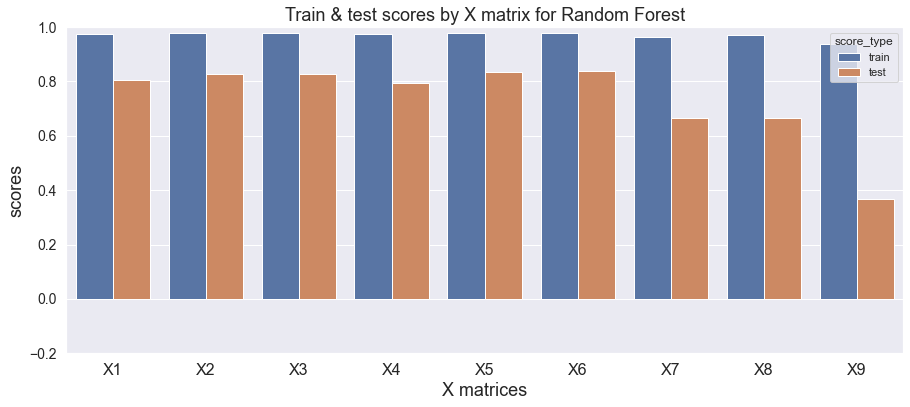

In [146]:
# Print results as a dataframe and barplot
plot_results(list_X_names=list_X_names, 
             train_scores_r2=train_scores_r2, 
             test_scores_r2=test_scores_r2, 
             model_name="Random Forest")

### Conclusion for the interest of ENERGYSTARScore in predicting TotalGHGEmissions
Use of ENERGYSTARScore slightly improves TotalGHGEmissions (0.840 vs 0.836 on X6 matrix)